## Model Selection Rationale

Why Transformer models are good choices over any other LSTMs or GRUs?

Transformer models are preferred over other traditional models for the classification of text-based data due to several key reasons:

1. Attention Mechanism: Transformers use the self-attention mechanism to capture contextual dependencies between words in a sentence. This allows the model to weigh the importance of each word concerning all other words in the sentence, enabling it to understand the long-range dependencies and relationships within the text effectively.

2. Bidirectional Context: Unlike traditional models like RNNs (Recurrent Neural Networks) that process text sequentially, transformers are bidirectional and can see both the left and right context of each word simultaneously. This bidirectional context enables transformers to capture a richer understanding of the text and make more informed decisions during classification tasks.

3. Parallelization: Transformers can process the tokens in parallel, making them more computationally efficient compared to sequential models like RNNs. This parallelization allows for faster training and inference, which is crucial when dealing with large text datasets.

4. Transfer Learning: Pre-trained transformer models like BERT, ELECTRA, GPT, etc., have been trained on massive amounts of textual data, learning general language patterns and semantic representations. These pre-trained models can be fine-tuned on specific classification tasks with smaller datasets, providing a significant boost in performance and reducing the need for extensive labeled data.

5. Hierarchical Representations: Transformers create hierarchical representations of text, where the lower layers capture word-level semantics, and higher layers capture sentence-level semantics. This hierarchical structure enables the model to understand different levels of abstractions in the text, leading to more powerful representations.

6. Contextual Word Embeddings: Transformers generate contextual word embeddings, where the representation of each word depends on the entire sentence's context. This context-awareness leads to better word representations and disambiguation of polysemous words.

Some papers for references
1. "Attention Is All You Need" by Vaswani et al. (The original Transformer paper) - https://arxiv.org/abs/1706.03762
This paper introduces the Transformer model, which uses self-attention mechanisms to process input sequences in parallel and efficiently capture long-range dependencies.

2. "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" by Devlin et al. - https://arxiv.org/abs/1810.04805
This paper introduces BERT, which demonstrates that pre-training a transformer model on a large corpus and fine-tuning it on specific tasks leads to state-of-the-art performance across various NLP tasks, including text classification.




## Why Electra Model over BERT and others

1. Pre-training Approach: ELECTRA introduces a novel pre-training objective called "Contrastive Learning of Structured Representations" which is different from the masked language modeling objective used in BERT. ELECTRA generates "fake" inputs and tries to predict which parts of the input have been replaced (discriminator task), while the generator task tries to generate those replaced inputs. This approach is found to be more sample-efficient and allows for better generalization in the downstream tasks compared to masked language modeling.

2. Efficiency: ELECTRA is generally more computationally efficient than BERT during both pre-training and fine-tuning. This is because ELECTRA only requires pre-training the smaller generator model, whereas BERT pre-training involves training the entire masked language model.

3. Better Performance: In some NLP benchmarks, ELECTRA has been shown to achieve better performance compared to BERT, especially on tasks with limited labeled data. The contrastive learning objective in ELECTRA is believed to help the model learn more robust and semantically meaningful representations.

4. Adaptive Computation Time: ELECTRA employs an adaptive computation time approach, where the generator model dynamically computes the representations of different input spans. This mechanism can potentially lead to more efficient utilization of computational resources.

Papers-
"ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators" by Kevin Clark et al. (https://openreview.net/pdf?id=r1xMH1BtvB)


In [1]:
# Installing Packages
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00


In [2]:
# Imports
import torch
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import pandas as pd

In [3]:
# These lines of code are just to set an warning off
import transformers
transformers.logging.set_verbosity_error()

In [4]:
# Loading the data into a DataFrame
data = pd.read_csv('/content/preprocessed_df.csv')
data

,Unnamed: 0,title,paragraph,news_list,event_timestamp
0,0,covid grinch cancel santa rally stock market,opinion stock market typically trade higher ti...,Supplier Market,2021-12-20T12:34:00Z
1,1,spdr sp xop etf multiyear uptrend buy dip,spdr sp oil gas exploration production etf xop...,Financial Health,2021-12-20T12:31:00Z
2,2,britain report new omicron case major incident...,total number omicron case recorded across coun...,Environmental,2021-12-20T12:31:00Z
3,3,risk aversion sentiment continues percolate,risk aversion sentiment rapid spread omicron c...,Commodities,2021-12-20T12:30:00Z
4,4,omicron rush booster may make harder stop rise...,country saying three vaccine dos needed protec...,Commodities,2021-12-20T12:16:00Z
...,...,...,...,...,...
1995,1995,covid case rise u omicron half state video,coronavirus infection increasing nearly every ...,Financial Health,2021-12-14T01:37:00Z
1996,1996,factbox bank tighten covid precaution omicron ...,u bank proactive industry encouraging employee...,Financial Health,2021-12-14T01:33:00Z
1997,1997,new sarscov variant wakeup call u industrializ...,new variant sarscov first isolated characteriz...,Commodities,2021-12-14T01:28:00Z
1998,1998,five new symptom omicron new variant differs o...,nh website still asks anyone three traditional...,Environmental,2021-12-14T01:26:00Z


In [5]:
# Convert the 'event_timestamp' column to Unix timestamps to be used in our model
from datetime import datetime

def convert_time(x):
  datetime_obj = datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ")
  # to get time in seconds
  unix_timestamp = datetime_obj.timestamp()
  return int(unix_timestamp)

data['event_timestamp'] = data['event_timestamp'].apply(lambda x:convert_time(x))

In [6]:
data

,Unnamed: 0,title,paragraph,news_list,event_timestamp
0,0,covid grinch cancel santa rally stock market,opinion stock market typically trade higher ti...,Supplier Market,1640003640
1,1,spdr sp xop etf multiyear uptrend buy dip,spdr sp oil gas exploration production etf xop...,Financial Health,1640003460
2,2,britain report new omicron case major incident...,total number omicron case recorded across coun...,Environmental,1640003460
3,3,risk aversion sentiment continues percolate,risk aversion sentiment rapid spread omicron c...,Commodities,1640003400
4,4,omicron rush booster may make harder stop rise...,country saying three vaccine dos needed protec...,Commodities,1640002560
...,...,...,...,...,...
1995,1995,covid case rise u omicron half state video,coronavirus infection increasing nearly every ...,Financial Health,1639445820
1996,1996,factbox bank tighten covid precaution omicron ...,u bank proactive industry encouraging employee...,Financial Health,1639445580
1997,1997,new sarscov variant wakeup call u industrializ...,new variant sarscov first isolated characteriz...,Commodities,1639445280
1998,1998,five new symptom omicron new variant differs o...,nh website still asks anyone three traditional...,Environmental,1639445160


In [7]:
data = data.drop('Unnamed: 0', axis=1)

In [8]:
data.head()

,title,paragraph,news_list,event_timestamp
0,covid grinch cancel santa rally stock market,opinion stock market typically trade higher ti...,Supplier Market,1640003640
1,spdr sp xop etf multiyear uptrend buy dip,spdr sp oil gas exploration production etf xop...,Financial Health,1640003460
2,britain report new omicron case major incident...,total number omicron case recorded across coun...,Environmental,1640003460
3,risk aversion sentiment continues percolate,risk aversion sentiment rapid spread omicron c...,Commodities,1640003400
4,omicron rush booster may make harder stop rise...,country saying three vaccine dos needed protec...,Commodities,1640002560


In [9]:
# Mapping the labels to numerical fields, to be understood by our model.
# Although we can use one hot encoding or label encoding from sklearn, I prefer to do it manually,
# to ensure proper consistency in inference models
labels = {
    "Environmental": 0,
    "Commodities": 1,
    "Delays": 2,
    "Financial Health": 3,
    "Compliance": 4,
    "Supplier Market": 5
}
data['news_list'] = data['news_list'].apply(lambda x:labels[x])

In [10]:
data['news_list'].value_counts()

0    545
1    506
2    365
3    303
4    160
5    121
Name: news_list, dtype: int64

In [24]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(val_data, test_size=0.5, random_state=42)

In [12]:
# Load the ELECTRA tokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

In [13]:
# Set the maximum sequence length for padding
max_length = 256

In [14]:
class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        news = self.data.iloc[idx]
        title = news['title']
        paragraph = news['paragraph']
        label = news['news_list']
        timestamp = news['event_timestamp']

        # Encoding the inputs using the tokenizer
        encoding = self.tokenizer.encode_plus( # encode_plus because of the extra text label
            title + f'T[{timestamp}]', # Timestamp appended to title
            text_pair=paragraph, # text pair used when two we have more than one label
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            #'timestamp': torch.tensor(timestamp, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [25]:
# Create the DataLoader for training and validation sets
train_dataset = NewsDataset(train_data, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = NewsDataset(val_data, tokenizer, max_length)
val_loader = DataLoader(val_dataset, batch_size=64)

test_dataset = NewsDataset(test_data, tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=64)

In [16]:
# Setting the training mode to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# Load the ELECTRA model for sequence classification
model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=6)
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [18]:
# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
# Training loop
num_epochs = 20

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
best_val_accuracy = 0.0
train_losses = []
val_losses = []

In [20]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0

    # For every batch
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #timestamp = batch['timestamp'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        # Taking out outputs from the model
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Getting Predicted Labels, and choosing the one with highest probability
        predicted_labels = torch.argmax(logits, dim=1)
        total_correct += (predicted_labels == labels).sum().item()


        ## Code commented out in loss, later explained

        # Apply a weighted combination of cross-entropy loss and mean squared error (MSE) loss
        # to include the timestamp as an auxiliary task during training
        # We can adjust the weights (alpha and beta) based on our preference.
        alpha, beta = 1.0, 0.1
        loss = alpha * torch.nn.functional.cross_entropy(logits, labels) #+ beta * torch.nn.functional.mse_loss(outputs.logits, timestamp.unsqueeze(-1))
        total_loss += loss.item()

        # for gradient descent
        loss.backward()
        optimizer.step()

    train_accuracy = total_correct/len(train_data)
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    # Validation loop
    model.eval() # eval mode for validation
    total_correct = 0
    total_val_loss = 0

    # making sure no gradient flow in evaluation
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # getting predicted outputs and appending them
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            total_correct += (predicted_labels == labels).sum().item()

            val_loss = torch.nn.functional.cross_entropy(logits, labels)
            total_val_loss += val_loss.item()

    val_accuracy = total_correct / len(val_data)
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {average_loss:.4f} - Validation Loss: {val_loss:.4f} - Training Accuracy {train_accuracy:.4f} - Validation Accuracy: {val_accuracy:.4f}')

    # Save train and validation losses to CSV
    loss_df = pd.DataFrame({'Epoch': range(1, epoch + 2), 'Train Loss': train_losses, 'Validation Loss': val_losses})
    loss_df.to_csv('losses.csv', index=False)

    # Save model weights if validation accuracy is greater than previous
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print("Saving the model...")
        torch.save(model.state_dict(), 'best_model_weights.pth')

print('Training completed.')

Epoch 1/20 - Train Loss: 1.7506 - Validation Loss: 1.7136 - Training Accuracy 0.2462 - Validation Accuracy: 0.2975
Saving the model...
Epoch 2/20 - Train Loss: 1.6941 - Validation Loss: 1.6822 - Training Accuracy 0.2712 - Validation Accuracy: 0.3000
Saving the model...
Epoch 3/20 - Train Loss: 1.6500 - Validation Loss: 1.6001 - Training Accuracy 0.2794 - Validation Accuracy: 0.3375
Saving the model...
Epoch 4/20 - Train Loss: 1.5840 - Validation Loss: 1.5397 - Training Accuracy 0.3194 - Validation Accuracy: 0.3800
Saving the model...
Epoch 5/20 - Train Loss: 1.5232 - Validation Loss: 1.5136 - Training Accuracy 0.3581 - Validation Accuracy: 0.3900
Saving the model...
Epoch 6/20 - Train Loss: 1.4538 - Validation Loss: 1.4267 - Training Accuracy 0.4512 - Validation Accuracy: 0.4925
Saving the model...
Epoch 7/20 - Train Loss: 1.3958 - Validation Loss: 1.3968 - Training Accuracy 0.4575 - Validation Accuracy: 0.5050
Saving the model...
Epoch 8/20 - Train Loss: 1.3222 - Validation Loss: 1.41

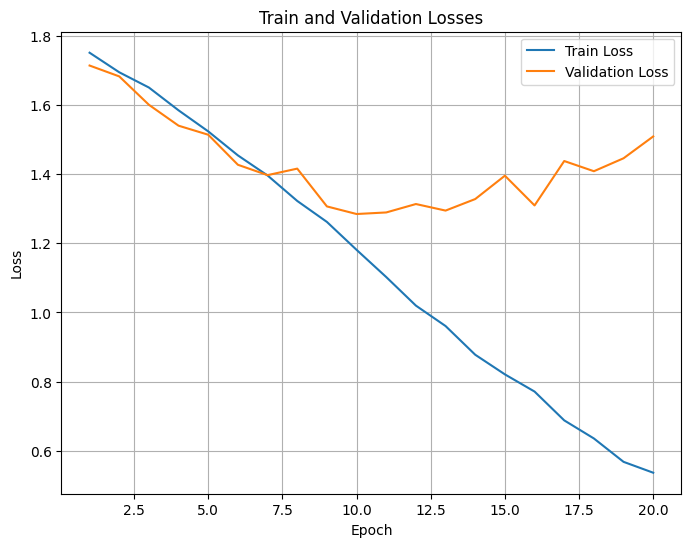

In [21]:
# Plotting the losses
import pandas as pd
import matplotlib.pyplot as plt

# Read the losses from the CSV file
loss_df = pd.read_csv('losses.csv')

# Extract the epoch, train loss, and validation loss
epochs = loss_df['Epoch']
train_losses = loss_df['Train Loss']
val_losses = loss_df['Validation Loss']

# Plot the train and validation losses
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

**Note:** The model I have used is the basic model of electra. Choosing a more powerful model with give better results

In [26]:
# Evaluation on Test Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=6)
model.load_state_dict(torch.load('best_model_weights.pth'))
model.to(device)

model.eval()
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Test Accuracy: 0.5500
Precision: 0.5656
Recall: 0.5500
F1-score: 0.5399


Why these metrics?

1. Accuracy: Accuracy is the ratio of correctly predicted labels to the total number of samples in the dataset. It measures the overall correctness of the model's predictions. While accuracy is a simple and intuitive metric, it may not be sufficient for imbalanced datasets where one class dominates over others. High accuracy doesn't necessarily mean the model is performing well, especially when classes are imbalanced.

2. Precision: Precision is the ratio of true positives to the sum of true positives and false positives. It measures the proportion of positive predictions that were correct. High precision indicates that the model makes fewer false positive errors, which is desirable when false positives are costly or undesirable.

3. Recall: Recall (also known as sensitivity or true positive rate) is the ratio of true positives to the sum of true positives and false negatives. It measures the proportion of actual positive samples that were correctly predicted by the model. High recall indicates that the model captures most of the positive samples, which is important when false negatives are costly or harmful.

4. F1-score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall and is especially useful when dealing with imbalanced datasets. The F1-score reaches its best value at 1 (perfect precision and recall) and worst value at 0.

## Some experiments I tried before giving off the best results

1. Adding the text and parapraph as a single field, without using timestamp. But, after adding 'text_pair' while encoding, improved the accuracy quite a bit
2. I tried to add the timestamp to the loss function as mse added to cross entropy. But, the losses were too high, and there weren't much changes across the dataset, becasue of the small lr. Increasing the lr would cause mayhem in cross-entropy loss. The only valid thing to do here, is to subtract the start of beginning of the first article, and pass on the deducted timestamp to the loss function. Also, multiply alpha and beta to both the coeffs to regularize.
3. Ultimately, adding the timestamp directly to the text, proved to the best in this case